# Season & Trend-Based Production Prediction

This notebook builds a model to predict production based on:
- **Seasonal patterns**: When items are sold (phase_in, phase_out dates)
- **Fashion trends**: Product categories, moments, archetypes
- **Temporal features**: Life cycle length, season ID
- **Business metrics**: Price, number of stores, sizes availability

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load train and test data
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain columns: {train.columns.tolist()}")
print(f"\nFirst few rows:")
train.head()

Train shape: (95339, 33)
Test shape: (2250, 33)

Train columns: ['ID', 'id_season', 'aggregated_family', 'family', 'category', 'fabric', 'color_name', 'color_rgb', 'image_embedding', 'length_type', 'silhouette_type', 'waist_type', 'neck_lapel_type', 'sleeve_length_type', 'heel_shape_type', 'toecap_type', 'woven_structure', 'knit_structure', 'print_type', 'archetype', 'moment', 'phase_in', 'phase_out', 'life_cycle_length', 'num_stores', 'num_sizes', 'has_plus_sizes', 'price', 'year', 'num_week_iso', 'weekly_sales', 'weekly_demand', 'Production']

First few rows:


,ID,id_season,aggregated_family,family,category,fabric,color_name,color_rgb,image_embedding,length_type,...,life_cycle_length,num_stores,num_sizes,has_plus_sizes,price,year,num_week_iso,weekly_sales,weekly_demand,Production
0,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,1,66,69,4556
1,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,2,112,112,4556
2,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,3,135,135,4556
3,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,4,99,99,4556
4,1,86,Dresses and jumpsuits,Dresses,"Dresses, jumpsuits and Complete set",WOVEN,AMARILLO,"255,215,0","0.072266474,-0.12752205,0.6080948,-1.2579741,-...",Long,...,12,152,5,False,35.99,2023,5,74,74,4556


## 2. Feature Engineering - Temporal & Seasonal Features

In [3]:
def engineer_temporal_features(df):
    """Extract temporal and seasonal features from dates"""
    df = df.copy()
    
    # Convert date columns to datetime
    df['phase_in'] = pd.to_datetime(df['phase_in'], format='%d/%m/%Y', errors='coerce')
    df['phase_out'] = pd.to_datetime(df['phase_out'], format='%d/%m/%Y', errors='coerce')
    
    # Extract temporal features from phase_in
    df['phase_in_month'] = df['phase_in'].dt.month
    df['phase_in_day'] = df['phase_in'].dt.day
    df['phase_in_dayofweek'] = df['phase_in'].dt.dayofweek
    df['phase_in_quarter'] = df['phase_in'].dt.quarter
    
    # Extract temporal features from phase_out
    df['phase_out_month'] = df['phase_out'].dt.month
    df['phase_out_quarter'] = df['phase_out'].dt.quarter
    
    # Season mapping based on month
    def get_season(month):
        if pd.isna(month):
            return np.nan
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    df['phase_in_season'] = df['phase_in_month'].apply(get_season)
    df['phase_out_season'] = df['phase_out_month'].apply(get_season)
    
    # Is same season throughout lifecycle
    df['same_season_lifecycle'] = (df['phase_in_season'] == df['phase_out_season']).astype(int)
    
    # Create interaction features
    df['price_per_store'] = df['price'] / (df['num_stores'] + 1)
    df['price_per_size'] = df['price'] / (df['num_sizes'] + 1)
    
    return df

# Apply feature engineering
train_fe = engineer_temporal_features(train)
test_fe = engineer_temporal_features(test)

print("Temporal features created!")
print(f"\nNew features: {[col for col in train_fe.columns if col not in train.columns]}")
train_fe[['phase_in', 'phase_in_month', 'phase_in_season', 'life_cycle_length']].head()

Temporal features created!

New features: ['phase_in_month', 'phase_in_day', 'phase_in_dayofweek', 'phase_in_quarter', 'phase_out_month', 'phase_out_quarter', 'phase_in_season', 'phase_out_season', 'same_season_lifecycle', 'price_per_store', 'price_per_size']


,phase_in,phase_in_month,phase_in_season,life_cycle_length
0,2023-01-02,1,Winter,12
1,2023-01-02,1,Winter,12
2,2023-01-02,1,Winter,12
3,2023-01-02,1,Winter,12
4,2023-01-02,1,Winter,12


## 3. Prepare Features for Modeling

In [4]:
def prepare_features(train_df, test_df):
    """Prepare features for modeling"""
    
    # Categorical columns to encode
    cat_columns = ['aggregated_family', 'family', 'category', 'fabric', 'color_name',
                   'length_type', 'silhouette_type', 'waist_type', 'neck_lapel_type',
                   'sleeve_length_type', 'heel_shape_type', 'toecap_type', 
                   'woven_structure', 'knit_structure', 'print_type', 
                   'archetype', 'moment', 'phase_in_season', 'phase_out_season']
    
    # Numeric features
    numeric_features = ['id_season', 'life_cycle_length', 'num_stores', 'num_sizes', 
                       'price', 'phase_in_month', 'phase_in_day', 'phase_in_dayofweek',
                       'phase_in_quarter', 'phase_out_month', 'phase_out_quarter',
                       'same_season_lifecycle', 'price_per_store', 'price_per_size']
    
    # Boolean features
    train_df['has_plus_sizes'] = train_df['has_plus_sizes'].map({'true': 1, 'false': 0, True: 1, False: 0})
    test_df['has_plus_sizes'] = test_df['has_plus_sizes'].map({'true': 1, 'false': 0, True: 1, False: 0})
    numeric_features.append('has_plus_sizes')
    
    # Encode categorical variables
    label_encoders = {}
    for col in cat_columns:
        if col in train_df.columns:
            le = LabelEncoder()
            # Combine train and test to fit encoder
            combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)])
            le.fit(combined)
            train_df[col + '_encoded'] = le.transform(train_df[col].astype(str))
            test_df[col + '_encoded'] = le.transform(test_df[col].astype(str))
            label_encoders[col] = le
    
    # Select features
    feature_cols = numeric_features + [col + '_encoded' for col in cat_columns if col in train_df.columns]
    
    # Fill missing values
    for col in feature_cols:
        if col in train_df.columns:
            train_df[col] = train_df[col].fillna(train_df[col].median() if train_df[col].dtype != 'object' else 'missing')
            test_df[col] = test_df[col].fillna(test_df[col].median() if test_df[col].dtype != 'object' else 'missing')
    
    return train_df, test_df, feature_cols, label_encoders

# Prepare features
train_prep, test_prep, feature_columns, encoders = prepare_features(train_fe, test_fe)

print(f"Total features: {len(feature_columns)}")
print(f"\nFeatures: {feature_columns[:10]}...")  # Show first 10

Total features: 34

Features: ['id_season', 'life_cycle_length', 'num_stores', 'num_sizes', 'price', 'phase_in_month', 'phase_in_day', 'phase_in_dayofweek', 'phase_in_quarter', 'phase_out_month']...


## 4. Train Season-Based Model

In [5]:
# Prepare X and y
X = train_prep[feature_columns]
y = train_prep['Production']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Target stats: mean={y.mean():.2f}, std={y.std():.2f}, min={y.min()}, max={y.max()}")

X shape: (95339, 34)
y shape: (95339,)
Target stats: mean=28927.42, std=34792.57, min=90, max=403172


In [6]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (76271, 34)
Validation set: (19068, 34)


In [7]:
# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

# Evaluation
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)

print(f"\n--- Random Forest Results ---")
print(f"Train MAE: {train_mae:.2f} | Val MAE: {val_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")
print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



--- Random Forest Results ---
Train MAE: 129.88 | Val MAE: 169.75
Train RMSE: 265.48 | Val RMSE: 345.53
Train R²: 0.9999 | Val R²: 0.9999


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


In [8]:
# Train Gradient Boosting model
print("Training Gradient Boosting model...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    verbose=1
)

gb_model.fit(X_train, y_train)

# Predictions
y_pred_train_gb = gb_model.predict(X_train)
y_pred_val_gb = gb_model.predict(X_val)

# Evaluation
train_mae_gb = mean_absolute_error(y_train, y_pred_train_gb)
val_mae_gb = mean_absolute_error(y_val, y_pred_val_gb)
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_train_gb))
val_rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_val_gb))
train_r2_gb = r2_score(y_train, y_pred_train_gb)
val_r2_gb = r2_score(y_val, y_pred_val_gb)

print(f"\n--- Gradient Boosting Results ---")
print(f"Train MAE: {train_mae_gb:.2f} | Val MAE: {val_mae_gb:.2f}")
print(f"Train RMSE: {train_rmse_gb:.2f} | Val RMSE: {val_rmse_gb:.2f}")
print(f"Train R²: {train_r2_gb:.4f} | Val R²: {val_r2_gb:.4f}")

Training Gradient Boosting model...
      Iter       Train Loss   Remaining Time 
         1  1104931491.3387            2.16m
         1  1104931491.3387            2.16m
         2  1001581240.0254            2.19m
         2  1001581240.0254            2.19m
         3   908275274.0697            2.24m
         3   908275274.0697            2.24m
         4   823741269.3483            2.23m
         4   823741269.3483            2.23m
         5   747586521.0728            2.19m
         5   747586521.0728            2.19m
         6   678693268.7950            2.15m
         6   678693268.7950            2.15m
         7   616253836.9143            2.12m
         7   616253836.9143            2.12m
         8   560094176.4407            2.08m
         8   560094176.4407            2.08m
         9   508970707.8072            2.06m
         9   508970707.8072            2.06m
        10   462621380.5952            2.06m
        10   462621380.5952            2.06m
        20   18354

In [9]:
# Choose the best model based on validation MAE
if val_mae < val_mae_gb:
    best_model = rf_model
    best_model_name = "Random Forest"
    print(f"\n✓ Best model: {best_model_name} (Val MAE: {val_mae:.2f})")
else:
    best_model = gb_model
    best_model_name = "Gradient Boosting"
    print(f"\n✓ Best model: {best_model_name} (Val MAE: {val_mae_gb:.2f})")


✓ Best model: Random Forest (Val MAE: 169.75)


## 5. Feature Importance Analysis

Top 20 Most Important Features:
                      feature  importance
2                  num_stores    0.464793
1           life_cycle_length    0.273271
12            price_per_store    0.134316
13             price_per_size    0.024971
6                phase_in_day    0.012035
19         color_name_encoded    0.011169
30          archetype_encoded    0.008982
3                   num_sizes    0.008509
18             fabric_encoded    0.007520
21    silhouette_type_encoded    0.005874
5              phase_in_month    0.004703
9             phase_out_month    0.004672
23    neck_lapel_type_encoded    0.004302
33   phase_out_season_encoded    0.003908
22         waist_type_encoded    0.003353
15  aggregated_family_encoded    0.003329
0                   id_season    0.003040
20        length_type_encoded    0.002656
16             family_encoded    0.002070
31             moment_encoded    0.001940


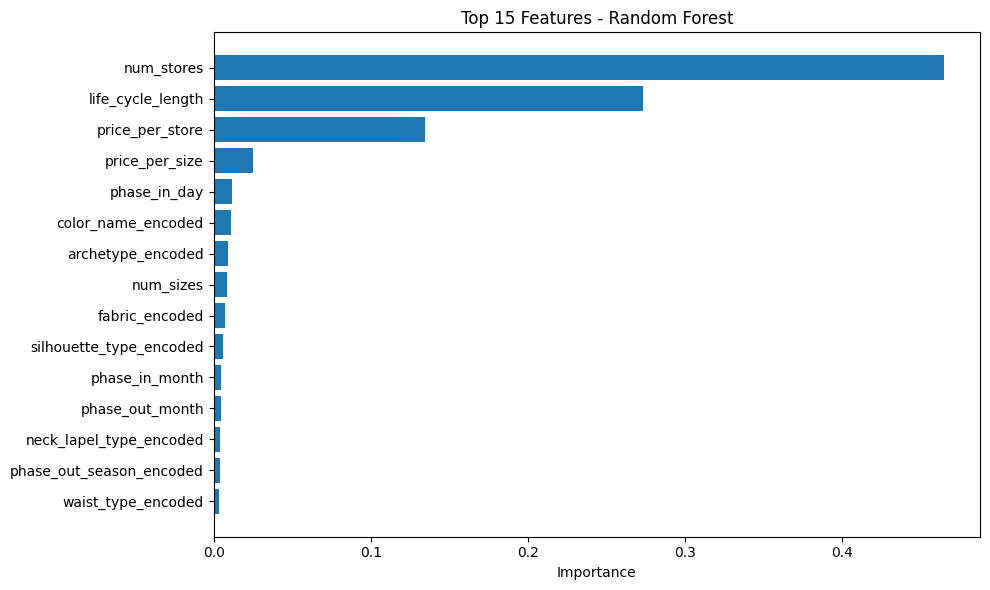

In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title(f'Top 15 Features - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Generate Predictions for Test Set

In [11]:
# Prepare test features
X_test = test_prep[feature_columns]

# Generate predictions
season_predictions = best_model.predict(X_test)

# Create submission dataframe
season_submission = pd.DataFrame({
    'ID': test['ID'],
    'Production': season_predictions
})

# Ensure predictions are positive
season_submission['Production'] = season_submission['Production'].clip(lower=0)

print(f"Test predictions generated!")
print(f"Predictions stats: mean={season_predictions.mean():.2f}, min={season_predictions.min():.2f}, max={season_predictions.max():.2f}")
print(f"\nFirst few predictions:")
season_submission.head(10)

Test predictions generated!
Predictions stats: mean=26861.85, min=310.45, max=249628.22

First few predictions:


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


,ID,Production
0,90,5348.073672
1,16,13235.378818
2,65,19699.748843
3,138,2613.682057
4,166,3078.679484
5,252,48242.170444
6,234,33316.263330
7,306,31537.290565
8,274,107245.994134
9,268,1042.052956


In [12]:
# Save predictions for ensemble
season_submission.to_csv('season_predictions.csv', index=False)
print("✓ Saved predictions to 'season_predictions.csv'")

✓ Saved predictions to 'season_predictions.csv'
